# CODICE COME MAIN_METROPOLIS_LU CHE CERCA DI USARE IL NETWORK DEL PROF 14/05/2025


## 1 Initialize the Network

In [64]:
import numpy as np 
import random 
import matplotlib.pyplot as plt 
import networkx as nx
import math
from itertools import combinations
import seaborn as sns

In [65]:
### PER PROF

# Carica la matrice fc (ad esempio dal file fc.txt)
fc = np.loadtxt('fc.txt')

# Crea la matrice A0 inizialmente vuota (di dimensioni 100x100)
n = fc.shape[0]
A0 = np.zeros((n, n))

# Per ogni coppia di nodi (i, j), crea una connessione se un numero casuale <= fc[i, j]
for i in range(n):
    for j in range(n):
        
        prob = fc[i, j]
        rand_value = np.random.rand()  # Genera un numero casuale tra 0 e 1
        if rand_value <= prob:
            A0[i, j] = 1  # Connetti i nodi i e j
        

# Adjacent matrix 
print(A0)

[[1. 0. 1. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]]


In [ ]:
# Graph creation
G_obs = nx.from_numpy_array(A0)

# Verifica numero di nodi e archi
print(f"Numero di nodi: {G_obs.number_of_nodes()}")
print(f"Numero di archi: {G_obs.number_of_edges()}")

Numero di nodi: 100
Numero di archi: 1271


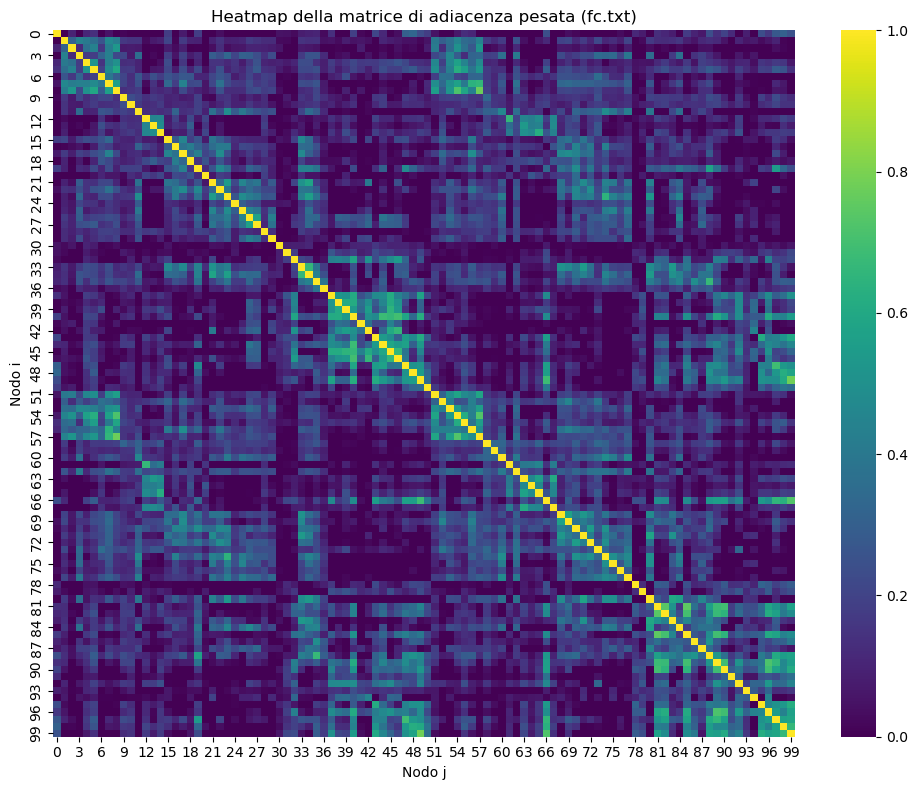

Grado medio (numero collegamenti): 25.42
Clustering medio pesato: 0.35


In [ ]:
### per visualizzare la rete

# === Heatmap della matrice di adiacenza ===
plt.figure(figsize=(10, 8))
sns.heatmap(fc, cmap='viridis')
plt.title('Heatmap della matrice di adiacenza pesata (fc.txt)')
plt.xlabel('Nodo j')
plt.ylabel('Nodo i')
plt.tight_layout()
plt.show()

# === Analisi di base ===
# Grado medio (non pesato)
avg_degree = np.mean([d for n, d in G_obs.degree()])
print(f"Grado medio (numero collegamenti): {avg_degree:.2f}")

# Clustering medio (pesato)
clustering = nx.clustering(G_obs, weight='weight')
avg_clustering = np.mean(list(clustering.values()))
print(f"Clustering medio pesato: {avg_clustering:.2f}")


In [ ]:
##### PLOTS 
def plot_graph(G):
    """
    Plots the given graph with node colors based on their block assignment.

    :param G: NetworkX graph object.
    """
    pos = nx.spring_layout(G)  # Compute node positions
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, edge_color='darkgray', node_color='skyblue', node_size=100, font_size=8, font_color='black')
    plt.title("Observed Graph")
    plt.show()
    


def plot_H_trace(H_burn_in, H_full_trace):
    """
    Plots the full trace of H(P), including the burn-in phase and sampling.

    :param H_burn_in: List of H(P) values during the burn-in phase.
    :param H_full_trace: List of H(P) values during the full MCMC sampling.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(H_burn_in)), H_burn_in, marker=',', linestyle='-', linewidth=0.7, label="Burn-in")
    plt.plot(range(len(H_burn_in), len(H_burn_in) + len(H_full_trace)), H_full_trace, marker=',', linestyle='-', linewidth=0.7, label="Sampling")
    plt.axvline(x=len(H_burn_in), color='r', linestyle='--', linewidth=1, label="End of burn-in")
    plt.xlabel("Iterations")
    plt.ylabel("H(P)")
    plt.title("Full Trace of H(P) Without Thinning")
    plt.legend()
    plt.show()


def plot_final_H_trace(H_final, thinning_interval):
    """
    Plots the final trace of H(P) after applying thinning.

    :param H_final: List of H(P) values after thinning.
    :param thinning_interval: Interval used for thinning.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(H_final)), H_final, marker='o', linestyle='-')
    plt.xlabel(f'Sampling iterations with thinning every {thinning_interval}')
    plt.ylabel('H(P)')
    plt.title('Final Trace of H(P) After Thinning')
    plt.show()


def plot_interaction_accuracies(error_fractions, accuracy_missing, accuracy_spurious):
    """
    Plots the accuracy for Missing and Spurious Interactions.

    :param error_fractions: List of error fractions.
    :param accuracy_missing: Accuracy values for missing interactions.
    :param accuracy_spurious: Accuracy values for spurious interactions.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot for Missing Interactions
    ax1.plot(error_fractions, accuracy_missing, 'ko-', markersize=8, label='Missing interactions')
    ax1.set_xlabel('Fraction of removed links (f)')
    ax1.set_ylabel('Accuracy (probability)')
    ax1.set_title('Missing Interactions')
    ax1.legend()
    ax1.grid(True)

    # Plot for Spurious Interactions
    ax2.plot(error_fractions, accuracy_spurious, 'ko-', markersize=8, label='Spurious interactions')
    ax2.set_xlabel('Fraction of added links (f)')
    ax2.set_ylabel('Accuracy (probability)')
    ax2.set_title('Spurious Interactions')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


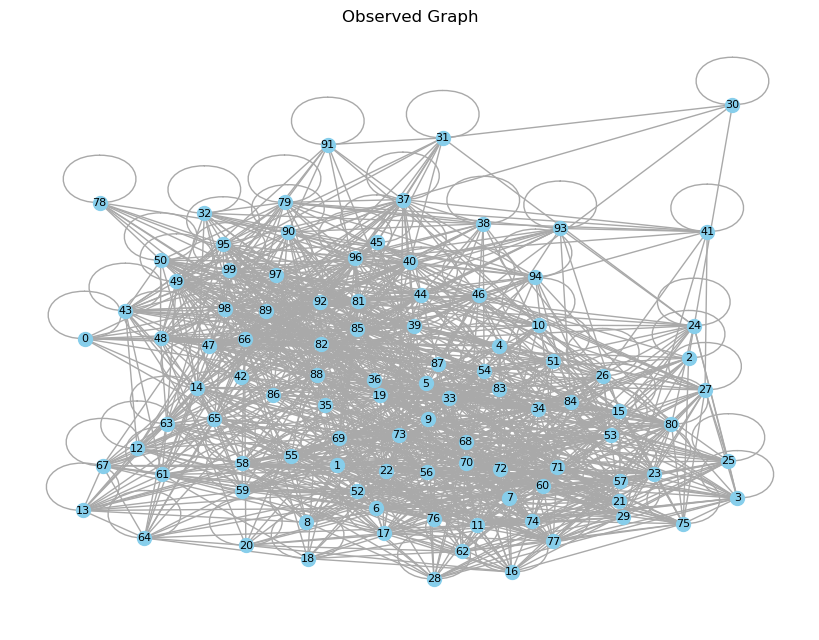

In [ ]:
plot_graph(G_obs)


### 1.2 Computing Entropy in Network Partitions

In [84]:
def initialize_partition(G):
    """Initialize random partitions (each node is its own group)."""
    num_nodes = len(G.nodes())
    return {node: random.choice(range(num_nodes)) for node in G.nodes()}  # Randomly assign each node to a group


def calculate_H(P, G):
    """Calculates H(P) for a given partition P and graph G."""
    # Group nodes by block
    block_nodes = {}
    for node, group in P.items():
        block_nodes.setdefault(group, []).append(node)

    lO = {}  # Observed links between blocks
    r = {}   # Possible links between blocks
    
    # Count links in the observed network
    for u, v in G.edges():
        gu, gv = P[u], P[v]
        key = tuple(sorted([gu, gv]))
        lO[key] = lO.get(key, 0) + 1
    
    # Compute rαβ (maximum possible links between groups)
    groups = list(block_nodes.keys())
    for g in groups:
        n = len(block_nodes[g])
        r[(g, g)] = n * (n - 1) // 2  # Combinations of 2
    # Pairs of different groups
    for g1, g2 in combinations(groups, 2):
        r[tuple(sorted([g1, g2]))] = len(block_nodes[g1]) * len(block_nodes[g2])
    
    # Compute H(P)
    H = 0.0
    for key in r:
        # Note: We add 1 to the denominator as per the formula and use log(comb) for the combinatorial term.
        H += math.log(r[key] + 1)
        # To avoid log(0) or errors, we use 0 if no observed links exist
        links = lO.get(key, 0)
        try:
            comb_value = math.comb(r[key], links) if r[key] >= links else 1
        except ValueError:
            comb_value = 1
        # For safety, if comb_value results in 0, we add a small epsilon
        H += math.log(comb_value)
    
    return H

# in caso aggiungo questo:
#if comb_value > 0:
    #H += math.log(comb_value)
#else:
    #H += 0


The formula for H(P) in your code:  
corresponds to the article's equation: [ H(P) = \sum_{\alpha \leq \beta} \left[ \ln(r_{\alpha\beta} + 1) + \ln\binom{r_{\alpha\beta}}{lO_{\alpha\beta}} \right] ]  
r[key] represents the maximum possible links between groups (denoted as ( r_{\alpha\beta} )).  
lO[key] represents the observed links between groups (denoted as ( lO_{\alpha\beta} )).  
The use of math.comb ensures the combinatorial term is calculated correctly.

### 1.3 MCMC Sampling for Network Partitions

This section introduces the Metropolis-Hastings MCMC algorithm to sample partitions of a given network. The function mcmc_trace_H performs the Markov Chain Monte Carlo (MCMC) sampling, first running a burn-in phase to reach equilibrium, then collecting partition samples without thinning. The acceptance criterion follows the Metropolis rule, ensuring that state transitions favor lower entropy configurations while allowing occasional increases for exploration. The output includes all recorded entropy values, enabling further analysis of the sampling process.

In [71]:
def metropolis_acceptance(delta_H):
    """Decides whether to accept a new state based on the Metropolis criterion."""
    return delta_H <= 0 or np.random.rand() < np.exp(-delta_H)


def mcmc_trace_H(G, equilibration=700, num_samples=50000):
    """
    Performs MCMC sampling, collecting all H(P) values without thinning.

    :param G: NetworkX graph for sampling.
    :param equilibration: Number of burn-in iterations.
    :param num_samples: Total number of sampling iterations.
    :return: List of sampled partitions, H values during sampling, and full trace of H values.
    """
    num_nodes = len(G.nodes())
    P = initialize_partition(G)
    
    # Store H(P) values during burn-in
    H_burn_in = []
    for i in range(equilibration):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        old_H = calculate_H(P, G)
        new_group = random.choice(range(num_nodes))
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        if not metropolis_acceptance(delta_H):
            P[node] = old_group
        H_burn_in.append(calculate_H(P, G))  # Store all H(P) values in burn-in
    
    # Sampling phase without thinning
    partitions = []
    H_full_trace = []  # Stores all H(P) values during sampling without thinning
    for i in range(num_samples):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        old_H = calculate_H(P, G)
        new_group = random.choice(range(num_nodes))
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        if not metropolis_acceptance(delta_H):
            P[node] = old_group
        partitions.append(P.copy())
        H_full_trace.append(calculate_H(P, G))  # Records all H(P) values without thinning
    
    return partitions, H_burn_in, H_full_trace





In [72]:
def autocorrelation(series, lag):
    """
    Computes the autocorrelation coefficient for a given time series and a specific lag.
    """
    n = len(series)
    if lag >= n:
        return 0
    series = np.array(series)
    mean = np.mean(series)
    c0 = np.sum((series - mean) ** 2) / n
    ct = np.sum((series[:n - lag] - mean) * (series[lag:] - mean)) / (n - lag)
    return ct / c0


def estimate_autocorrelation_time(series, max_lag=None, threshold=0.05):
    """
    Estimates the integrated autocorrelation time (tau_int) of the series.

    :param series: Time series (list or array) of sampled values (e.g., H(P)).
    :param max_lag: Maximum lag for computing autocorrelation. If None, defaults to len(series) // 2.
    :param threshold: Threshold to stop summation when autocorrelation falls below this value.
    :return: tau_int, the integrated autocorrelation time.
    """
    n = len(series)
    if max_lag is None:
        max_lag = n // 2

    tau_int = 1.0  # Includes t=0, where rho(0) = 1
    acfs = [1.0]  # Autocorrelation at lag 0 is always 1
    for lag in range(1, max_lag):
        rho = autocorrelation(series, lag)
        acfs.append(rho)
        # Stop summation if autocorrelation falls below the threshold
        if rho < threshold:
            break
    # Summing terms (multiplied by 2, as per standard formula)
    tau_int += 2 * np.sum(acfs[1:])
    return tau_int, acfs


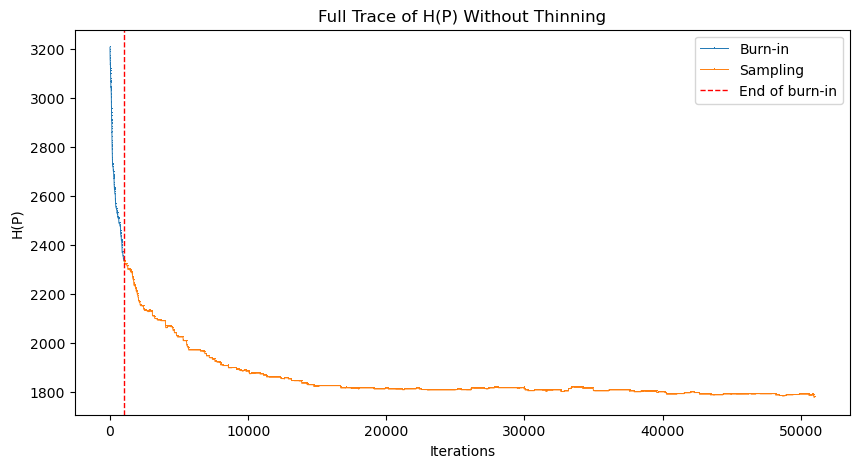

Integrated Autocorrelation Time (tau_int): 196.77
Recommended thinning every 197 iterations.


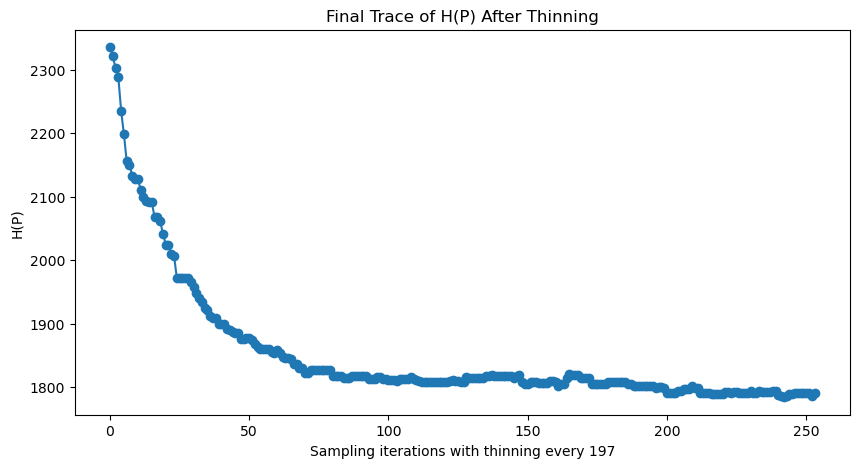

In [85]:
# Perform MCMC sampling on the observed network partitions, collecting the trace of H(P)
partitions, H_burn_in, H_full_trace = mcmc_trace_H(G_obs, equilibration=1000, num_samples=50000)

# Plot the H(P) trace
plot_H_trace(H_burn_in, H_full_trace)

# Compute the integrated autocorrelation time
tau_int, acfs = estimate_autocorrelation_time(H_full_trace, max_lag=100, threshold=0.05)
print(f"Integrated Autocorrelation Time (tau_int): {tau_int:.2f}")

# Choose thinning based on tau_int
thinning_interval = math.ceil(tau_int)
print(f"Recommended thinning every {thinning_interval} iterations.")



# Apply thinning to H(P) samples
H_final = H_full_trace[::thinning_interval]
# Apply thinning to partitions to obtain independent samples
partitions_thinned = partitions[::thinning_interval]

# Call the function to plot the final trace of H(P)
plot_final_H_trace(H_final, thinning_interval)

C:\Users\eugen\AppData\Local\Temp\ipykernel_18288\959360629.py:22: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(1, max_lag + 1), autocorr_values, use_line_collection=True)


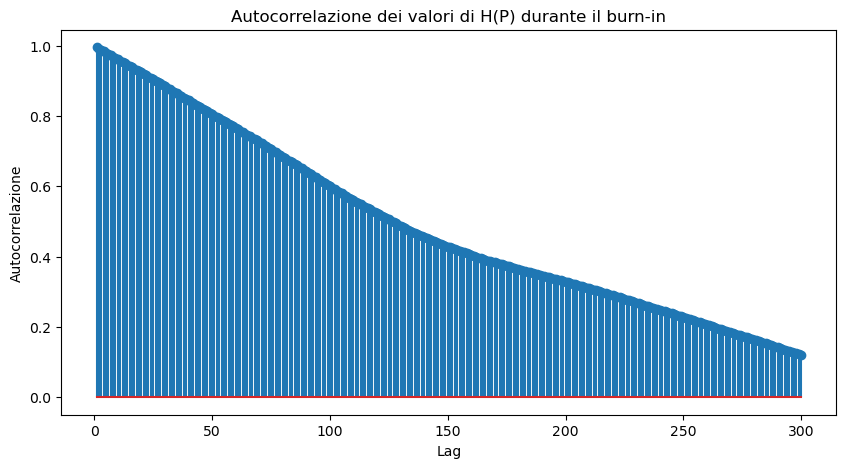

In [86]:
##### Poi questo lo togliamo, è solo per vedere come va l'autocorrelazione

def autocorrelation(series, max_lag):
    """ Calcola l'autocorrelazione per una serie di valori fino a max_lag. """
    n = len(series)
    mean = np.mean(series)
    c0 = np.sum((series - mean) ** 2) / n
    autocorrs = []

    for lag in range(1, max_lag + 1):
        ct = np.sum((series[:n - lag] - mean) * (series[lag:] - mean)) / (n - lag)
        autocorrs.append(ct / c0)

    return autocorrs

# Calcoliamo l'autocorrelazione per i valori di H(P) del burn-in
max_lag = 300  # Puoi variare questo valore per vedere fino a dove l'autocorrelazione decade
autocorr_values = autocorrelation(H_burn_in, max_lag)

# Plottiamo la funzione di autocorrelazione
plt.figure(figsize=(10, 5))
plt.stem(range(1, max_lag + 1), autocorr_values, use_line_collection=True)
plt.xlabel("Lag")
plt.ylabel("Autocorrelazione")
plt.title("Autocorrelazione dei valori di H(P) durante il burn-in")
plt.show()


## 2 Compute the reliabilities

### 2.1 Link Reliability

This section introduces the function *estimate_link_reliability*, which calculates the link reliability $RL_{ij}$ for each node pair $(i,j)$ in a network, following a probabilistic formulation.

- The function iterates over a set of sampled partitions and computes the probability of a link existing between nodes, based on observed and expected connections.

- It uses the entropy function $H(P)$ to weigh partitions, ensuring statistically significant estimates.

- The result provides a normalized reliability score, which helps infer missing or uncertain links in noisy network data.

This method is useful for network reconstruction, link prediction, and structural analysis under uncertainty.

In [ ]:
def estimate_link_reliability(G, partitions):
    """
    Estimates link reliability RL_ij for each pair (i, j) where i < j,
    using the formula:
    
    RL_ij = (1/Z) * sum_{P in partitions} [ (lO_{σ_iσ_j}+1)/(r_{σ_iσ_j}+2) * exp(-H(P) ) ]
    """
    # Initialize dictionary for RL for all pairs (i, j)
    nodes = list(G.nodes())
    reliability = {}
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            reliability[(i, j)] = 0.0

    Z = 0.0  # Normalization factor
    
    for P in partitions:
        weight = np.exp(-calculate_H(P, G))  ####### AGGIUNGERE C NELL'ESPONENZIALE
        Z += weight
        
        # Group nodes by block for partition P
        block_nodes = {}
        for node, group in P.items():
            block_nodes.setdefault(group, []).append(node)
        
        # Precompute r and lO for each pair of blocks in partition P
        r = {}
        lO = {}
        groups = list(block_nodes.keys())
        # For identical blocks
        for g in groups:
            n = len(block_nodes[g])
            r[(g, g)] = n * (n - 1) // 2
            # Count observed links within the block
            count = 0
            for u, v in combinations(block_nodes[g], 2):
                if G.has_edge(u, v):
                    count += 1
            lO[(g, g)] = count
        # For different block pairs
        for g1, g2 in combinations(groups, 2):
            key = tuple(sorted([g1, g2]))
            r[key] = len(block_nodes[g1]) * len(block_nodes[g2])
            count = 0
            for u in block_nodes[g1]:
                for v in block_nodes[g2]:
                    if G.has_edge(u, v):
                        count += 1
            lO[key] = count
        
        # Apply formula for each node pair (i, j) based on groups in P
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                g_i = P[nodes[i]]
                g_j = P[nodes[j]]
                key = tuple(sorted([g_i, g_j]))
                # If no observed links exist, lO defaults to 0
                current_lO = lO.get(key, 0)
                current_r = r.get(key, 1)  # Avoid division by zero
                reliability[(nodes[i], nodes[j])] += ((current_lO + 1) / (current_r + 2)) * weight

    # Normalize results
    for key in reliability:
        reliability[key] /= Z
    
    return reliability

In [ ]:
# Estimate link reliability for each node pair in the observed network
RL = estimate_link_reliability(G_obs, partitions)

# Print some results (e.g., for the first 10 pairs)
print("Link Reliability for selected node pairs:")
for i, key in enumerate(RL):
    #if i >= 30:
        #break
    print(f"Pair {key}: RL = {RL[key]:.4f}")


Link Reliability for selected node pairs:
Pair (0, 1): RL = 0.6690
Pair (0, 2): RL = 0.2843
Pair (0, 3): RL = 0.8364
Pair (0, 4): RL = 0.6800
Pair (0, 5): RL = 0.3795
Pair (0, 6): RL = 0.5319
Pair (0, 7): RL = 0.8315
Pair (0, 8): RL = 0.7811
Pair (0, 9): RL = 0.6907
Pair (0, 10): RL = 0.2680
Pair (0, 11): RL = 0.5321
Pair (0, 12): RL = 0.1696
Pair (0, 13): RL = 0.1588
Pair (0, 14): RL = 0.3658
Pair (0, 15): RL = 0.3672
Pair (0, 16): RL = 0.4237
Pair (0, 17): RL = 0.1800
Pair (0, 18): RL = 0.4701
Pair (0, 19): RL = 0.3199
Pair (0, 20): RL = 0.5336
Pair (0, 21): RL = 0.5338
Pair (0, 22): RL = 0.4833
Pair (0, 23): RL = 0.3791
Pair (0, 24): RL = 0.6859
Pair (0, 25): RL = 0.7532
Pair (0, 26): RL = 0.5137
Pair (0, 27): RL = 0.7374
Pair (0, 28): RL = 0.7158
Pair (0, 29): RL = 0.8033
Pair (0, 30): RL = 0.8073
Pair (0, 31): RL = 0.4739
Pair (0, 32): RL = 0.4696
Pair (0, 33): RL = 0.2776
Pair (0, 34): RL = 0.8220
Pair (0, 35): RL = 0.7815
Pair (0, 36): RL = 0.6286
Pair (1, 2): RL = 0.5672
Pair (

#### 2.1.1 Ranking Probability for Missing and Spurious Interactions in Networks

In [ ]:
def rank_probability_missing_interactions(G_true, G_obs, RL):
    """
    Computes the probability that a false negative (AO=0, AT=1) has a higher RL
    than a true negative (AO=0, AT=0).
    
    G_true: True network (AT)
    G_obs: Observed network (AO)
    RL: Dictionary of link reliability for each pair (i, j) with i < j.
    """
    false_negatives = []  # AO=0, AT=1
    true_negatives = []   # AO=0, AT=0
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    # Build lists of node pairs based on definitions
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 0:
                if A_true[i, j] == 1:
                    false_negatives.append(RL[(i, j)])
                else:
                    true_negatives.append(RL[(i, j)])
    
    # If there are no examples, return None or 0
    if not false_negatives or not true_negatives:
        return None
    
    count = 0
    total = 0
    # For each pair, add 1 if the false negative has a higher RL than the true negative,
    # 0.5 if they are equal.
    for fn in false_negatives:
        for tn in true_negatives:
            total += 1
            if fn > tn:
                count += 1
            elif fn == tn:
                count += 0.5
    probability = count / total
    return probability


def rank_probability_spurious_interactions(G_true, G_obs, RL):
    """
    Computes the probability that a false positive (AO=1, AT=0) has a lower RL
    than a true positive (AO=1, AT=1).
    
    G_true: True network (AT)
    G_obs: Observed network (AO)
    RL: Dictionary of link reliability for each pair (i, j) with i < j.
    """
    false_positives = []  # AO=1, AT=0
    true_positives = []   # AO=1, AT=1
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 1:
                if A_true[i, j] == 0:
                    false_positives.append(RL[(i, j)])
                else:
                    true_positives.append(RL[(i, j)])
    
    if not false_positives or not true_positives:
        return None
    
    count = 0
    total = 0
    # Here we want the false positive to have a lower RL than the true positive,
    # meaning in descending order the true positive should come first.
    for fp in false_positives:
        for tp in true_positives:
            total += 1
            if fp < tp:
                count += 1
            elif fp == tp:
                count += 0.5
    probability = count / total
    return probability




In [ ]:
# Compute the probability for missing interactions (false negatives)
p_missing = rank_probability_missing_interactions(G_true, G_obs, RL)
if p_missing is not None:
    print(f"Probability that a false negative has a higher RL than a true negative: {p_missing:.4f}")
else:
    print("Not enough examples for missing interactions.")
    
# Compute the probability for spurious interactions (false positives)
p_spurious = rank_probability_spurious_interactions(G_true, G_obs, RL)
if p_spurious is not None:
    print(f"Probability that a false positive has a lower RL than a true positive: {p_spurious:.4f}")
else:
    print("Not enough examples for spurious interactions.")

Probability that a false negative has a higher RL than a true negative: 0.6330
Probability that a false positive has a lower RL than a true positive: 0.5843


#### 2.1.2 Accuracy of Missing and Spurious Interactions in Network Reconstruction

In [ ]:
def calculate_accuracies(G_true, error_fractions, num_samples=1000, equilibration=100):
    accuracy_missing = []
    accuracy_spurious = []

    # --- Missing Interactions ---
    for f in error_fractions:
        G_obs_missing = G_true.copy()
        edges = list(G_true.edges())
        num_remove = int(len(edges) * f)

        if num_remove == 0:  # Special case
            accuracy_missing.append(1.0)
            continue

        remove_indices = np.random.choice(len(edges), num_remove, replace=False)
        for idx in remove_indices:
            G_obs_missing.remove_edge(*edges[idx])

        parts_missing, H_burn_in_missing, H_full_trace_missing = mcmc_trace_H(G_obs_missing, equilibration, num_samples)
        RL_missing = estimate_link_reliability(G_obs_missing, parts_missing)
        p_missing = rank_probability_missing_interactions(G_true, G_obs_missing, RL_missing)

        if p_missing is None:  # Case with no false negatives or true negatives
            accuracy_missing.append(1.0)
        else:
            accuracy_missing.append(p_missing)

    # --- Spurious Interactions ---
    for f in error_fractions:
        G_obs_spurious = G_true.copy()
        non_edges = list(nx.non_edges(G_true))
        num_to_add = int(len(G_true.edges()) * f)

        if num_to_add == 0:  # Special case
            accuracy_spurious.append(1.0)
            continue

        add_indices = np.random.choice(len(non_edges), num_to_add, replace=False)
        for idx in add_indices:
            G_obs_spurious.add_edge(*non_edges[idx])

        parts_spurious, H_burn_in_spurious, H_full_trace_spurious = mcmc_trace_H(G_obs_spurious, equilibration, num_samples)
        RL_spurious = estimate_link_reliability(G_obs_spurious, parts_spurious)
        p_spurious = rank_probability_spurious_interactions(G_true, G_obs_spurious, RL_spurious)

        if p_spurious is None:  # Case with no false positives or true positives
            accuracy_spurious.append(1.0)
        else:
            accuracy_spurious.append(p_spurious)

    return accuracy_missing, accuracy_spurious




In [ ]:
# Compute accuracy values
error_fractions = np.linspace(0.05, 0.9, 10)
accuracy_missing, accuracy_spurious = calculate_accuracies(G_true, error_fractions)

# Call the function to generate both plots
plot_interaction_accuracies(error_fractions, accuracy_missing, accuracy_spurious)

ValueError: Cannot take a larger sample than population when 'replace=False'

### 2.2 Network reliability   -  <span style="color: RED;"> DA QUI IN POI SISTEMARE</span>

#### suggerimento copilot
Numerical Stability:

Ensure that the combinatorial term ( \ln\binom{r_{\alpha\beta}}{lO_{\alpha\beta}} ) does not cause overflow for large values of ( r_{\alpha\beta} ). Consider using logarithmic approximations for factorials if necessary.

Efficiency:

The nested loops in calculate_H and estimate_link_reliability may become computationally expensive for large networks. Optimizing these calculations (e.g., vectorization) could improve performance.

Validation:

Test the implementation on small, well-understood networks (e.g., toy examples) to verify that the calculated ( H(P) ) and link reliabilities match expected values.